In [1]:
import os
import glob

import tensorflow as tf
from keras_video import VideoFrameGenerator

In [2]:
classes = [i.split(os.path.sep)[1] for i in glob.glob('Dataset/*')]
classes.sort()

In [3]:
SIZE = (320, 240)
CHANNELS = 3
NBFRAME = 5
BS = 8

In [4]:
# for data augmentation
data_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

In [5]:
glob_pattern='Dataset/{classname}/*.mp4'

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class 0, validation count: 9, train count: 21
class 1, validation count: 9, train count: 21
Total data: 2 classes for 42 files for train


In [6]:
valid = train.get_validation_generator()

Total data: 2 classes for 18 files for validation


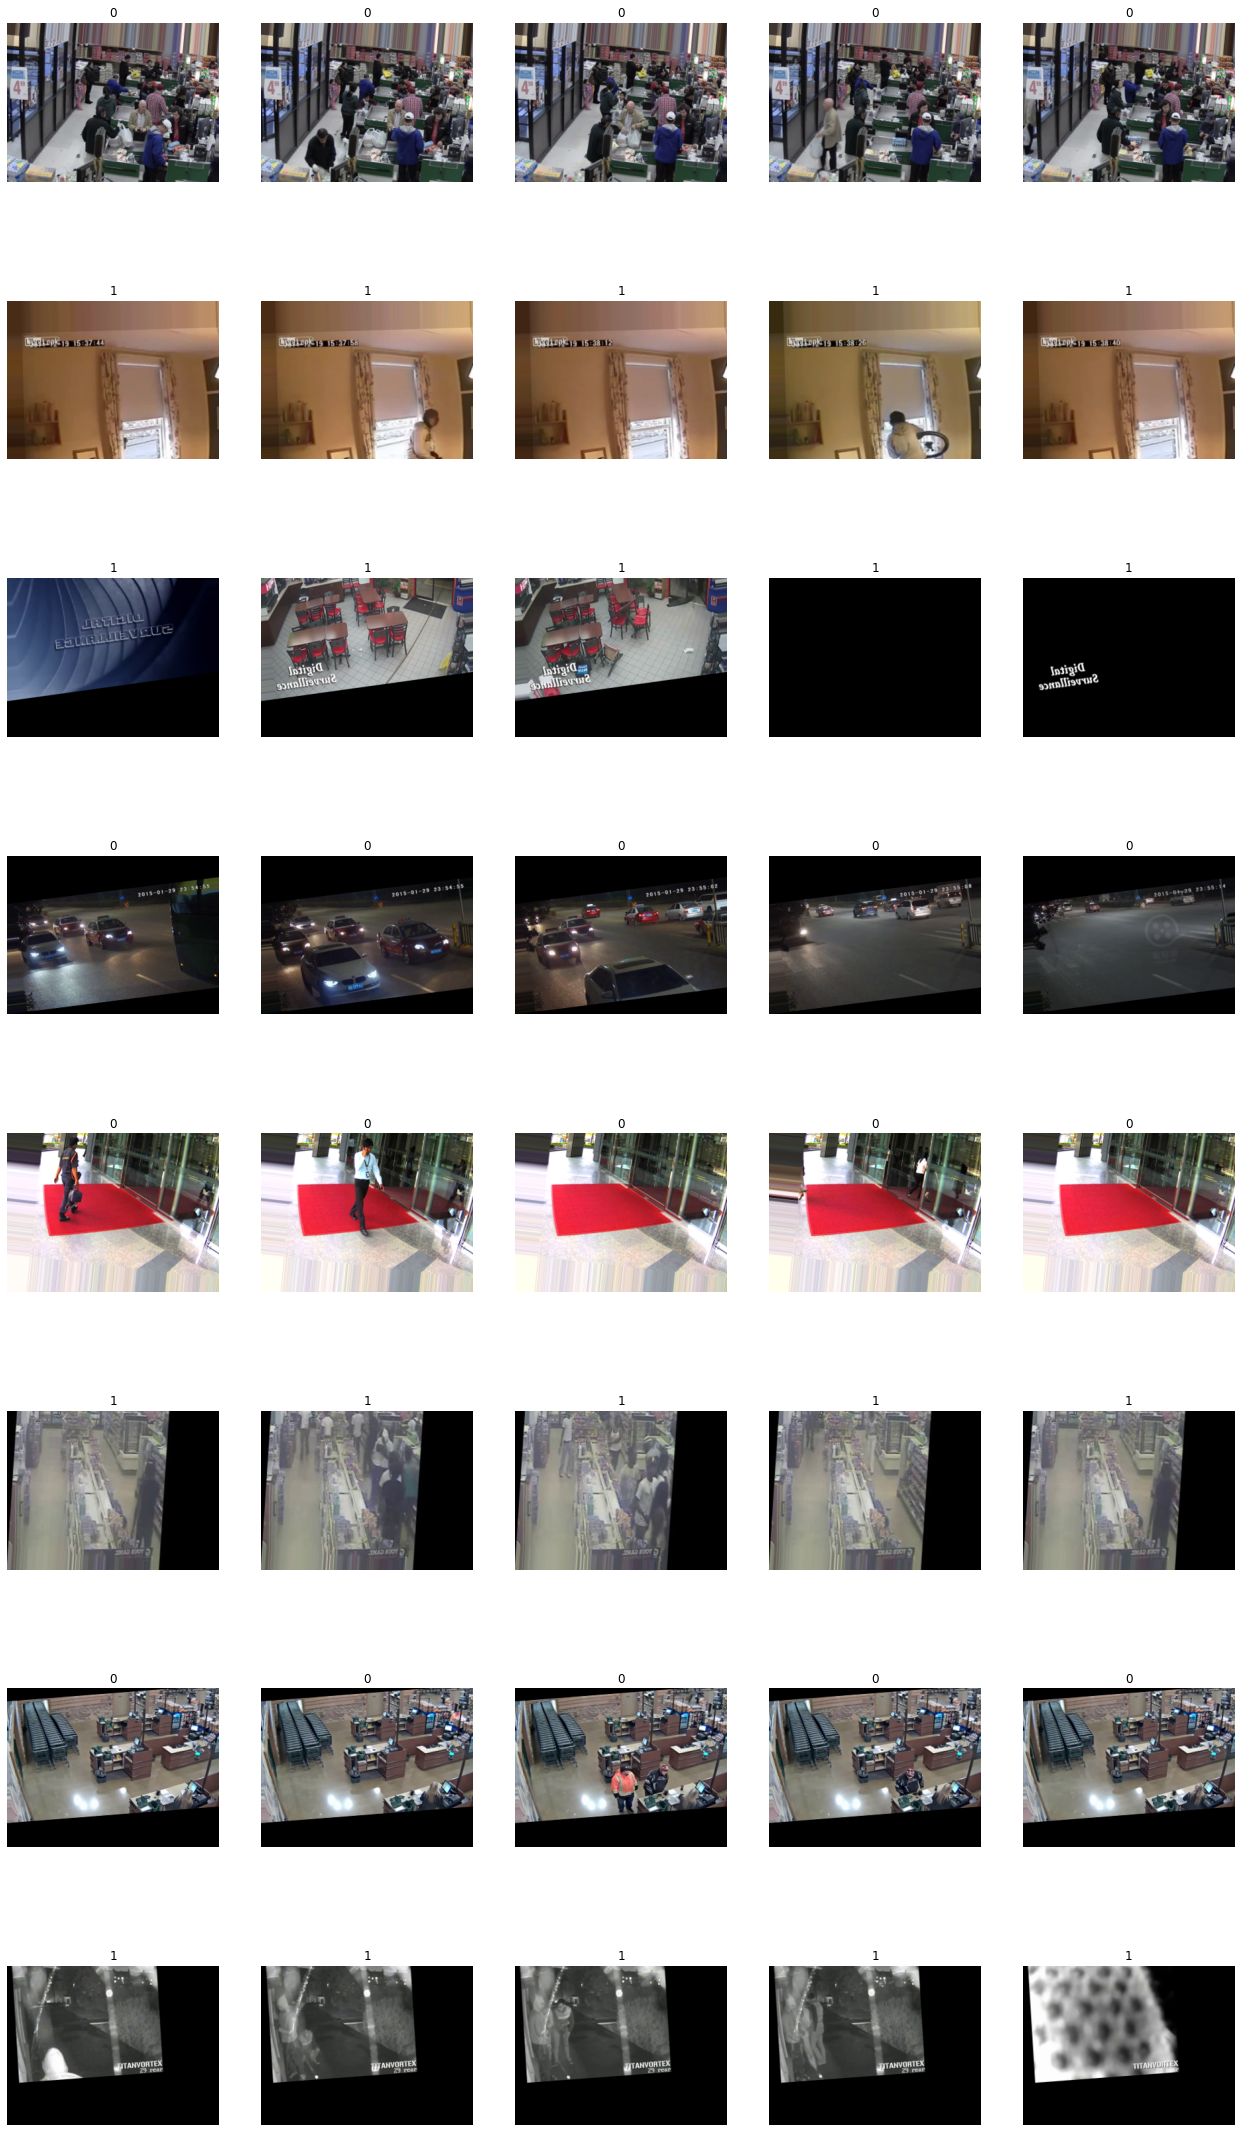

In [7]:
import keras_video.utils
keras_video.utils.show_sample(train)

### Overall code for Building model:

To replace this with my code...

```python
def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model
```

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model, Sequential

def build_resnet(shape=(240, 320, 3)):
    baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=shape))
    
    for layer in baseModel.layers:
        layer.trainable = False
        
    headModel = GlobalAvgPool2D()
    model = Sequential([baseModel, headModel])
    
    return model


from tensorflow.keras.layers import TimeDistributed, GRU

def action_model(shape=(5, 240, 320, 3), nbout=2):
    # Create our convnet with (240, 320, 3) input shape
    resnet = build_resnet(shape[1:])
    
    # then create our final model
    model = Sequential()
    
    # add the convnet with (5, 240, 320, 3) shape
    model.add(TimeDistributed(resnet, input_shape=shape))
    
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    
    return model

In [9]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 240, 320, 3)
model = action_model(INSHAPE, len(classes))
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

In [11]:
EPOCHS=100

history = model.fit_generator(
    train,
    validation_data=valid,
    epochs=EPOCHS
)

Epoch 1/5
5/5 [==============================] - 4s 867ms/step - loss: 0.7538 - acc: 0.5250 - val_loss: 0.6913 - val_acc: 0.5625
Epoch 2/5
5/5 [==============================] - 5s 888ms/step - loss: 0.7357 - acc: 0.4750 - val_loss: 0.7222 - val_acc: 0.5000
Epoch 3/5
5/5 [==============================] - 5s 978ms/step - loss: 0.6511 - acc: 0.5500 - val_loss: 0.7213 - val_acc: 0.4375
Epoch 4/5
5/5 [==============================] - 5s 906ms/step - loss: 0.6761 - acc: 0.5500 - val_loss: 0.7324 - val_acc: 0.4375
Epoch 5/5
5/5 [==============================] - 5s 905ms/step - loss: 0.7434 - acc: 0.5000 - val_loss: 0.6865 - val_acc: 0.5625


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

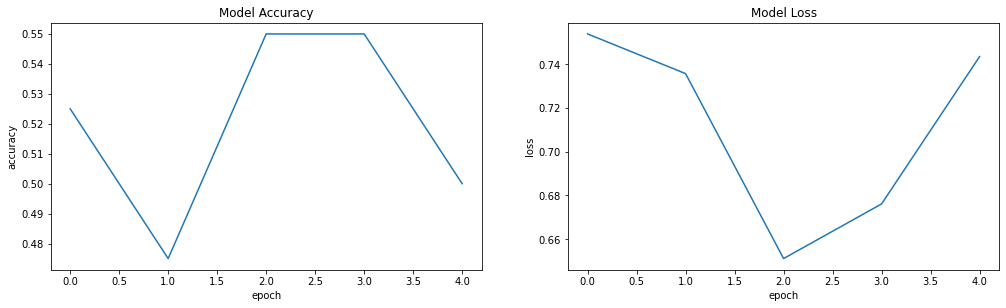

In [15]:
plt.figure(1, figsize = (17,10)) 
    
plt.subplot(221)  
plt.plot(history.history['acc'])
plt.title('Model Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  

plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.title('Model Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')

plt.show()

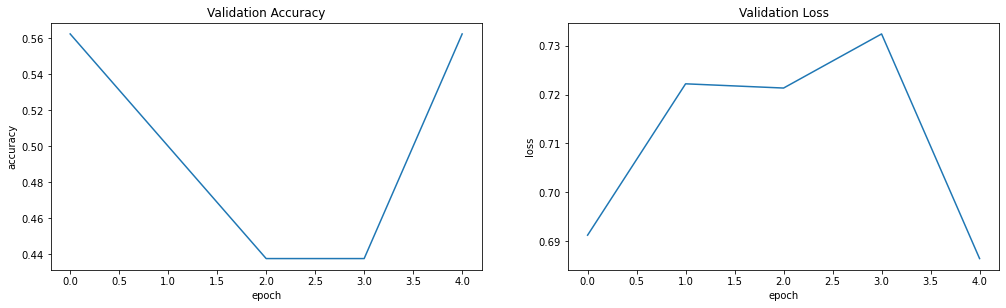

In [16]:
plt.figure(1, figsize = (17,10)) 
    
plt.subplot(221)  
plt.plot(history.history['val_acc'])
plt.title('Validation Accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  

plt.subplot(222)  
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')

plt.show()